# HiFive Unmatched Power Analysis

This notebook shows how to perform a simple power analysis of a workload running on the [SiFive HiFive Unmatched](https://www.sifive.com/boards/hifive-unmatched) development board. 

### The SiFive Freedom U740 SoC
The HiFive Unmatched development board is powered by the SiFive Freedom U740 (FU740), an SoC that includes a high-performance multi-core, 64-bit dual-issue, superscalar RISC-V processor (SiFive Essential™ U74-MC) with 16GB of DDR4, Gigabit Ethernet, PCIe expansion, USB 3, and M.2 sockets for Wi-Fi, Bluetooth and NVMe storage. 
A 5th core (a SiFive Essential S71 monitor core) is available for real time applications. 
SiFive Mix+Match technology offers a potent combination of application and real-time processing. The S71 (RV64IMAC) can service auxiliary functions and cooperate with the U74-MC cluster, making this an ideal heterogeneous software development platform where Linux and a RTOS can co-exist.

### The Power Analysis
The [SiFive HiFive Unmatched](https://www.sifive.com/boards/hifive-unmatched) board features a set of nine power lines available on-boards with embedded shunt resistors for current monitoring.
The available power lines are: `core`, `ddr_soc`, `io`, `pll`, `pcievp`, `pcievph`, `ddr_mem`, `ddr_pll`, and `ddr_vpp`.
The power consumption of the board is estimated by multiplying the voltage produced by each power line regulator, measured at the positive end of the shunt resistor, by the current signal across each shunt.
The current signal is obtained by measuring the voltage drop on each shunt with a National Instruments `PXIe-4309` data acquisition module. 

In [1]:
import numpy
import pandas
import pathlib

import matplotlib.pyplot as plt

import hifivepm

## Global Variables & Functions

In [2]:
TDMS_DIR_PATH = pathlib.Path.cwd() / "HiFive-Unmatched"
if not TDMS_DIR_PATH.is_dir():
    raise ValueError(f"Base directory `{TDMS_DIR_PATH}` not found")
print(f"Load TDMS file in the {TDMS_DIR_PATH} directory")

TDMS_PATHS = {}
for p in TDMS_DIR_PATH.glob("*.tdms"):
    print(f"\t{p.stem} : ({p})")
    TDMS_PATHS[p.stem] = p

Load TDMS file in the /home/eparisi/work/HiFive-Power-Monitor/examples/HiFive-Unmatched directory
	Boot : (/home/eparisi/work/HiFive-Power-Monitor/examples/HiFive-Unmatched/Boot.tdms)


In [3]:
TDMS_GROUP_NAME = "PXIe-4309"
print(f"Default group name: {TDMS_GROUP_NAME}")

Default group name: PXIe-4309


In [4]:
print(f"Power line voltage characterization")
POWER_LINE_VOLTAGE = pandas.Series({
    "core":    0.918,
    "ddr_soc": 1.199,
    "io":      1.791,
    "pll":     1.789,
    "pcievp":  0.926,
    "pcievph": 1.793,
    "ddr_mem": 1.199,
    "ddr_pll": 0.916,
    "ddr_vpp": 2.469
})
for l, v in POWER_LINE_VOLTAGE.items():
    print(f"\t{l:7} : {v} V") 

Power line voltage characterization
	core    : 0.918 V
	ddr_soc : 1.199 V
	io      : 1.791 V
	pll     : 1.789 V
	pcievp  : 0.926 V
	pcievph : 1.793 V
	ddr_mem : 1.199 V
	ddr_pll : 0.916 V
	ddr_vpp : 2.469 V


In [5]:
def make_power_report(current):
    """
    """
    df = current * POWER_LINE_VOLTAGE
    df.insert(current.shape[1], "tot", df.sum(axis=1))

    return df

def make_energy_report(power_report):
    """
    """
    t = power_report.index.to_numpy()
    f = numpy.reciprocal(numpy.diff(t)).mean().round()
    e = power_report.sum() / f
    df = pandas.DataFrame([
        e,
        100*e / e["tot"]
    ])
    df.index = [
        "energy [J]",
        "energy [%]"
    ]

    return df

## Power Analysis

In [6]:
raw, meta = hifivepm.read_tdms(
    TDMS_PATHS["Boot"],
    TDMS_GROUP_NAME
)

### Power report

In [7]:
report_p = make_power_report(raw)
report_p.describe()

,core,ddr_soc,io,pll,pcievp,pcievph,ddr_mem,ddr_pll,ddr_vpp,tot
count,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000,119000.000000
mean,3.443647,0.168323,0.022486,0.001236,0.377331,0.400466,0.384892,0.022181,0.090659,4.911221
std,1.340428,0.063426,0.009145,0.000603,0.209653,0.231719,0.150447,0.010281,0.042267,1.991610
min,0.010483,0.001208,-0.000531,-0.000083,0.010347,-0.042166,-0.004442,-0.000106,-0.017152,-0.037617
25%,3.603286,0.163758,0.026188,0.001512,0.276245,0.393382,0.406366,0.026877,0.099544,5.024913
50%,4.024557,0.185135,0.026727,0.001516,0.539497,0.556805,0.427325,0.026923,0.101760,5.878465
75%,4.188625,0.204249,0.026857,0.001520,0.541592,0.557793,0.450053,0.026953,0.112960,6.062551
max,4.947425,0.460288,0.040339,0.003275,0.546766,0.572740,0.916267,0.027039,0.179777,7.415877


array([<AxesSubplot: xlabel='Time [s]'>, <AxesSubplot: xlabel='Time [s]'>,
       <AxesSubplot: xlabel='Time [s]'>, <AxesSubplot: xlabel='Time [s]'>,
       <AxesSubplot: xlabel='Time [s]'>], dtype=object)

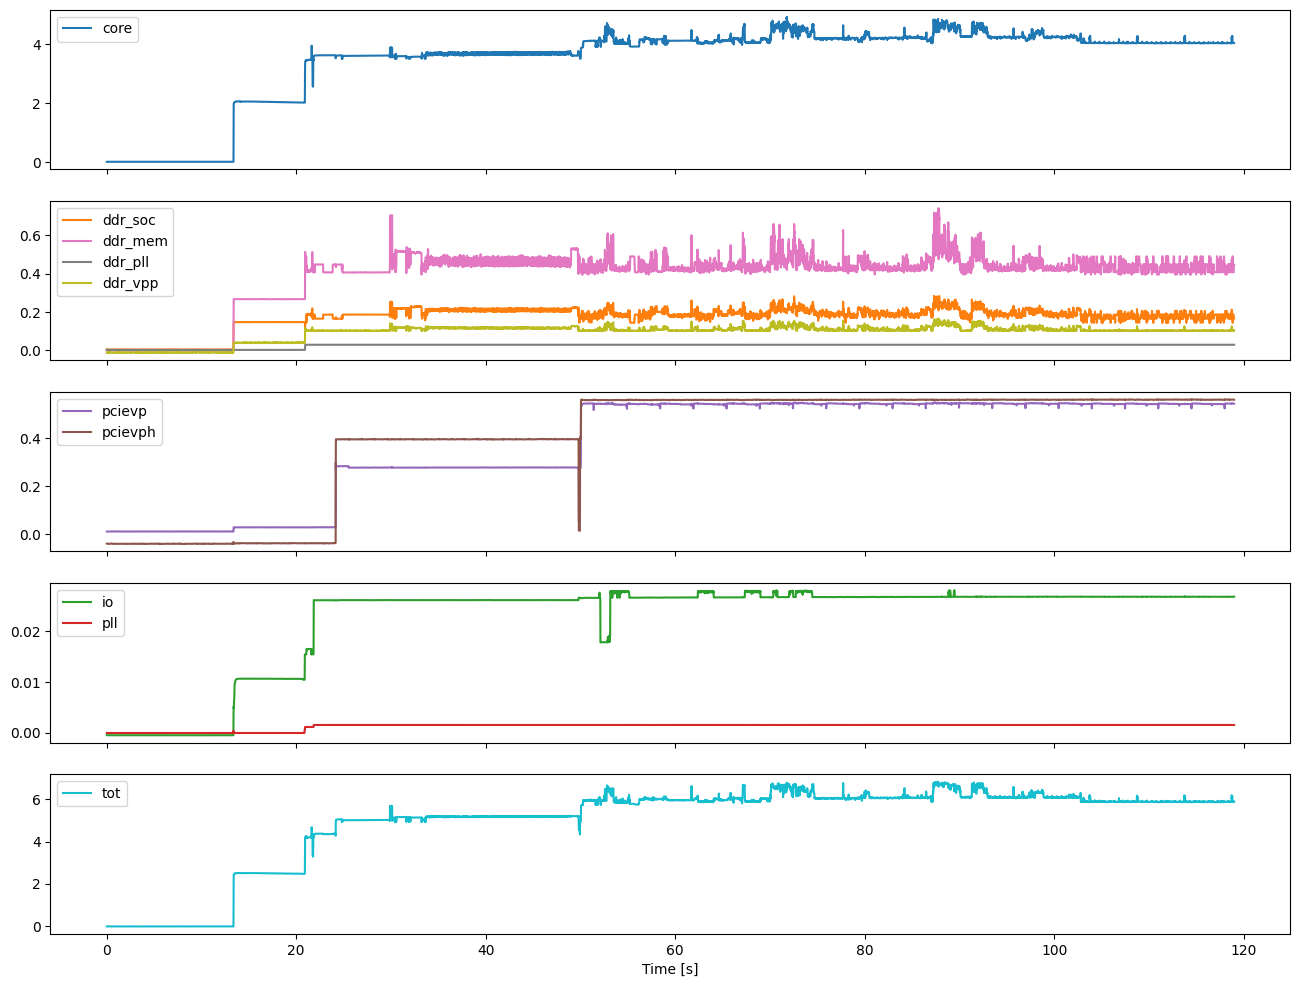

In [8]:
report_p.rolling(10, step=10).mean().plot(
    figsize=(16, 12), 
    subplots=[
        ("core",), 
        ("ddr_soc", "ddr_mem", "ddr_vpp", "ddr_pll"),
        ("pcievp", "pcievph"),
        ("io", "pll")
    ],
    xlabel="Time [s]",
    use_index=True,
    sharex=True
)

### Energy report

In [9]:
report_e = make_energy_report(report_p)
report_e

,core,ddr_soc,io,pll,pcievp,pcievph,ddr_mem,ddr_pll,ddr_vpp,tot
energy [J],409.794028,20.030437,2.675858,0.147076,44.902332,47.655487,45.802166,2.639500,10.788462,584.435347
energy [%],70.117940,3.427315,0.457854,0.025166,7.683028,8.154108,7.836995,0.451632,1.845963,100.000000
